In [84]:
install.packages("readr")
library(readr)

install.packages("dplyr")
library(dplyr)

Warning message:
"pakiet 'readr' jest w użyciu i nie zostanie zainstalowany"
Warning message:
"pakiet 'dplyr' jest w użyciu i nie zostanie zainstalowany"


**Funkacja convert, która zamienia separator dziesiętny na przecinek oraz typ zmiennej numeric na intiger**

In [85]:
convert_commas_to_dots <- function(df) {
  # Zamiana przecinków na kropki w kolumnach typu
  #character tylko jeśli zawierają przecinek
  df[] <- lapply(df, function(x) {
    if (is.character(x) && any(grepl(",", x))) {
      x <- gsub(",", ".", x)
      num_x <- suppressWarnings(as.numeric(x))
      if (all(is.na(num_x) & !is.na(x))) {
        return(x) # Jeśli wszystkie wartości stają się NA, pozostaw jako tekst
      } else {
        return(num_x) # Konwersja na numeric, jeśli możliwe
      }
    } else {
      return(x)
    }
  })
  return(df)
}

convert_numeric_to_integer <- function(df) {

  #Zamiana wartości na integer, jeśli nie zawierają
  #kropki i nie są wszystkimi NA

  df[] <- lapply(df, function(x) {
    if (is.numeric(x) && all(!grepl("\\.", as.character(x)), na.rm = TRUE)) { 
      return(as.integer(x))
    } else {
      return(x)
    }
  })
  return(df)
}

In [86]:
convert <- function(df) {
  df <- convert_commas_to_dots(df)
  df <- convert_numeric_to_integer(df)
  return(df)
}

**Zaczytanie danych**

Błędy w zaczytywanych danych: 
- teams.csv ma podublowane rekordy, gdzie połowa z nuch jest niepoprawna. Należy usunąć wiersze, gdzie TM_TAG != TM_NAME
- teams.csv ma błędne ilości minut. Większość wartości w kolumnie MIN jest równa 200 (lub 225, 250, 300 w zależności od ilości dogrywek), gdyż zostały zsumowane z tabeli players.csv przez autora danych. Należy podzielić kolumnę MIN przez 5. 
- niespójność w players.csv. Część rekordów jest pomimo tego, że MIN = 0, co oznacza, że zawodnik nie wystąpił w meczu. Natomiast widać, że części rekordów nie ma, gdyż część zawodników ma mniejszą ilość rozegranych gier. Trzeba usunąć rekordy, gdzie MIN = 0, gdyż rodzi to problem przy zliczaniu ilości game played oraz liczeniu średniej. 

In [87]:
teams <- read_csv2("teams.csv")
players <- read_csv2("players.csv")

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.



Rows: 1324 Columns: 133
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (13): TM TAG, OPP TAG, TM NAME, OPP NAME, DATE, H/A, W/L, RIM PPS, MID ...
dbl (120): ROUND, MIN, PTS, 2PTM, 2PTA, 2PT%, 3PTM, 3PTA, 3PT%, FGM, FGA, FG...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 7883 Columns: 85
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (14): TM TAG, NAME, ROLE, NAT, HEIGHT, TM NAME, OPP NAME, DATE, H/A, W/L...
dbl (71): AGE, ROUND, MIN, PTS, 2PTM, 2PTA, 3PTM, 3PTA, FGM, FGA, FTM, FTA, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**Konwersja danych**

In [88]:
shortnames <- function(df) {
  map <- c(
    "Crvena Zvezda Meridianbet Belgrade" = "Crvena Zvezda",
    "LDLC ASVEL Villeurbanne" = "ASVEL",
    "Maccabi Playtika Tel Aviv" = "Maccabi Tel Aviv",
    "Partizan Mozzart Bet Belgrade" = "Partizan",
    "Anadolu Efes Istanbul" = "Efes",
    "FC Barcelona" = "Barcelona",
    "ALBA Berlin" = "ALBA",
    "FC Bayern Munich" = "Bayern",
    "Virtus Segafredo Bologna" = "Virtus Bologna",
    "Zalgiris Kaunas" = "Zalgiris",
    "EA7 Emporio Armani Milan" = "Olimpia Milan",
    "Fenerbahce Beko Istanbul" = "Fenerbahce",
    "Olympiacos Piraeus" = "Olympiacos",
    "Panathinaikos AKTOR Athens" = "Panathinaikos",
    "Baskonia Vitoria-Gasteiz" = "Baskonia",
    "Real Madrid" = "Real Madrid",
    "AS Monaco" = "Monaco",
    "Valencia Basket" = "Valencia"
  )
  
  if ("TM NAME" %in% names(df)) {
    df$`TM NAME` <- dplyr::recode(df$`TM NAME`, !!!map)
  }
  if ("OPP NAME" %in% names(df)) {
    df$`OPP NAME` <- dplyr::recode(df$`OPP NAME`, !!!map)
  }
  return(df)
}


In [89]:
teams <- shortnames(teams)
glimpse(teams)

Rows: 1,324
Columns: 133
$ ROUND              <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ `TM TAG`           <chr> "CZB", "ASV", "MTA", "PAR", "EFE", "FCB", "BER", "B…
$ `OPP TAG`          <chr> "ASV", "CZB", "PAR", "MTA", "FCB", "EFE", "BAY", "B…
$ `TM NAME`          <chr> "Crvena Zvezda", "ASVEL", "Maccabi Tel Aviv", "Part…
$ `OPP NAME`         <chr> "ASVEL", "Crvena Zvezda", "Partizan", "Maccabi Tel …
$ DATE               <chr> "05.10.2023", "05.10.2023", "05.10.2023", "05.10.20…
$ `H/A`              <chr> "H", "A", "H", "A", "A", "H", "A", "H", "H", "A", "…
$ `W/L`              <chr> "W", "L", "W", "L", "L", "W", "L", "W", "L", "W", "…
$ MIN                <dbl> 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 2…
$ PTS                <dbl> 94, 73, 96, 81, 74, 91, 68, 80, 79, 82, 82, 85, 88,…
$ `2PTM`             <dbl> 16, 17, 27, 26, 22, 32, 16, 23, 23, 18, 18, 18, 19,…
$ `2PTA`             <dbl> 37, 29, 43, 39, 40, 42, 30, 36, 39, 39, 36, 34, 35,…
$ `2PT%`       

In [90]:
players <- shortnames(players)
glimpse(players)

Rows: 7,883
Columns: 85
$ `TM TAG`       <chr> "CZB", "CZB", "CZB", "CZB", "CZB", "CZB", "CZB", "CZB",…
$ NAME           <chr> "Adam Hanga", "Branko Lazic", "Dalibor Ilic", "Luka Mit…
$ ROLE           <chr> "F", "SG", "F", "PF", "PF", "C", "PG", "SG", "C", "F/PF…
$ NAT            <chr> "HUN", "SRB", "BIH", "SRB", "SRB", "USA", "SRB", "SRB",…
$ HEIGHT         <chr> "201", "195", "206", "206", "203", "213", "195", "191",…
$ AGE            <dbl> 35, 35, 24, 31, 38, 30, 37, 33, 34, 32, 33, 28, 30, 35,…
$ ROUND          <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ `TM NAME`      <chr> "Crvena Zvezda", "Crvena Zvezda", "Crvena Zvezda", "Crv…
$ `OPP NAME`     <chr> "ASVEL", "ASVEL", "ASVEL", "ASVEL", "ASVEL", "ASVEL", "…
$ DATE           <chr> "05.10.2023", "05.10.2023", "05.10.2023", "05.10.2023",…
$ `H/A`          <chr> "H", "H", "H", "H", "H", "H", "H", "H", "H", "H", "H", …
$ `W/L`          <chr> "W", "W", "W", "W", "W", "W", "W", "W", "W", "W", "W", …
$ MIN           

In [91]:
teams <- convert(teams)
glimpse(teams)

Rows: 1,324
Columns: 133
$ ROUND              <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ `TM TAG`           <chr> "CZB", "ASV", "MTA", "PAR", "EFE", "FCB", "BER", "B…
$ `OPP TAG`          <chr> "ASV", "CZB", "PAR", "MTA", "FCB", "EFE", "BAY", "B…
$ `TM NAME`          <chr> "Crvena Zvezda", "ASVEL", "Maccabi Tel Aviv", "Part…
$ `OPP NAME`         <chr> "ASVEL", "Crvena Zvezda", "Partizan", "Maccabi Tel …
$ DATE               <chr> "05.10.2023", "05.10.2023", "05.10.2023", "05.10.20…
$ `H/A`              <chr> "H", "A", "H", "A", "A", "H", "A", "H", "H", "A", "…
$ `W/L`              <chr> "W", "L", "W", "L", "L", "W", "L", "W", "L", "W", "…
$ MIN                <int> 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 2…
$ PTS                <int> 94, 73, 96, 81, 74, 91, 68, 80, 79, 82, 82, 85, 88,…
$ `2PTM`             <int> 16, 17, 27, 26, 22, 32, 16, 23, 23, 18, 18, 18, 19,…
$ `2PTA`             <int> 37, 29, 43, 39, 40, 42, 30, 36, 39, 39, 36, 34, 35,…
$ `2PT%`       

In [92]:
players <- convert(players)
glimpse(players)

Rows: 7,883
Columns: 85
$ `TM TAG`       <chr> "CZB", "CZB", "CZB", "CZB", "CZB", "CZB", "CZB", "CZB",…
$ NAME           <chr> "Adam Hanga", "Branko Lazic", "Dalibor Ilic", "Luka Mit…
$ ROLE           <chr> "F", "SG", "F", "PF", "PF", "C", "PG", "SG", "C", "F/PF…
$ NAT            <chr> "HUN", "SRB", "BIH", "SRB", "SRB", "USA", "SRB", "SRB",…
$ HEIGHT         <chr> "201", "195", "206", "206", "203", "213", "195", "191",…
$ AGE            <int> 35, 35, 24, 31, 38, 30, 37, 33, 34, 32, 33, 28, 30, 35,…
$ ROUND          <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ `TM NAME`      <chr> "Crvena Zvezda", "Crvena Zvezda", "Crvena Zvezda", "Crv…
$ `OPP NAME`     <chr> "ASVEL", "ASVEL", "ASVEL", "ASVEL", "ASVEL", "ASVEL", "…
$ DATE           <chr> "05.10.2023", "05.10.2023", "05.10.2023", "05.10.2023",…
$ `H/A`          <chr> "H", "H", "H", "H", "H", "H", "H", "H", "H", "H", "H", …
$ `W/L`          <chr> "W", "W", "W", "W", "W", "W", "W", "W", "W", "W", "W", …
$ MIN           

In [93]:
# Podział danych na poszczególne etapy rozgrywek
# Dla zespołów
teams_regular_raw <- teams %>% filter(ROUND <= 34)
teams_playin_raw <- teams %>% filter(ROUND >= 35 & ROUND <= 36)
teams_playoff_raw <- teams %>% filter(ROUND >= 37 & ROUND <= 41)
teams_final4_raw  <- teams %>% filter(ROUND >= 42 & ROUND <= 43)

# Dla zawodników
players_regular <- players %>% filter(ROUND <= 34)
players_playin  <- players %>% filter(ROUND >= 35 & ROUND <= 36)
players_playoff <- players %>% filter(ROUND >= 37 & ROUND <= 41)
players_final4  <- players %>% filter(ROUND >= 42 & ROUND <= 43)

In [94]:
print(teams_playin_raw)

#Poniżej widać, że pojawiają się błędy w postaci niepotrzebnych recordów
#Należy usunąć wiersze, gdzie TM TAG jest niezgodny z TM NAME 
#np. 5 `TM TAG` = BAS, `TM NAME` = Maccabi Playtika Tel Aviv

# A tibble: 12 × 133
   ROUND `TM TAG` `OPP TAG` `TM NAME`   `OPP NAME` DATE  `H/A` `W/L`   MIN   PTS
   <int> <chr>    <chr>     <chr>       <chr>      <chr> <chr> <chr> <int> <int>
 1    35 BAS      MTA       Baskonia    Maccabi T… 16.0… A     L       200    85
 2    35 MTA      BAS       Maccabi Te… Baskonia   16.0… H     W       200   113
 3    35 EFE      VIR       Efes        Virtus Bo… 16.0… H     L       200    64
 4    35 VIR      EFE       Virtus Bol… Efes       16.0… A     W       200    67
 5    35 BAS      MTA       Maccabi Te… Baskonia   16.0… A     L       200   113
 6    35 MTA      BAS       Baskonia    Maccabi T… 16.0… H     W       200    85
 7    35 EFE      VIR       Virtus Bol… Efes       16.0… H     L       200    67
 8    35 VIR      EFE       Efes        Virtus Bo… 16.0… A     W       200    64
 9    36 BAS      VIR       Baskonia    Virtus Bo… 19.0… H     W       200    89
10    36 VIR      BAS       Virtus Bol… Baskonia   19.0… A     L       200    77
11    3

**Czyszczenie danych teams**

In [95]:
tag_name_map <- tibble(
  `TM TAG` = c("CZB", "ASV", "MTA", "PAR", "EFE", "FCB", "BER", "BAY",
               "VIR", "ZAL", "MIL", "FEN", "OLY", "PAN", "BAS", "RMB",
               "ASM", "VAL"),
  `TM NAME` = c("Crvena Zvezda",
                "ASVEL",
                "Maccabi Tel Aviv",
                "Partizan",
                "Efes",
                "Barcelona",
                "ALBA",
                "Bayern",
                "Virtus Bologna",
                "Zalgiris",
                "Olimpia Milan",
                "Fenerbahce",
                "Olympiacos",
                "Panathinaikos",
                "Baskonia",
                "Real Madrid",
                "Monaco",
                "Valencia")
)

print(tag_name_map)

# A tibble: 18 × 2
   `TM TAG` `TM NAME`       
   <chr>    <chr>           
 1 CZB      Crvena Zvezda   
 2 ASV      ASVEL           
 3 MTA      Maccabi Tel Aviv
 4 PAR      Partizan        
 5 EFE      Efes            
 6 FCB      Barcelona       
 7 BER      ALBA            
 8 BAY      Bayern          
 9 VIR      Virtus Bologna  
10 ZAL      Zalgiris        
11 MIL      Olimpia Milan   
12 FEN      Fenerbahce      
13 OLY      Olympiacos      
14 PAN      Panathinaikos   
15 BAS      Baskonia        
16 RMB      Real Madrid     
17 ASM      Monaco          
18 VAL      Valencia        


In [96]:
clean_names_tbox <- function(teams, tag_map) {
  teams %>%
    left_join(tag_map, by = "TM TAG") %>%   # Dopasowanie poprawnej nazwy
    filter(`TM NAME.x` == `TM NAME.y`) %>%  # Zachowanie tylko poprawnych nazw
    select(-`TM NAME.y`) %>%                # Usuwanie pomocniczej kolumny
    rename(`TM NAME` = `TM NAME.x`)         # Przywracanie oryginalnej nazwy
}


In [97]:
scale_minutes <- function(teams) {
  teams %>%
    mutate(`MIN` = as.integer(`MIN` / 5))   # Podzielenie liczby min przez 5
}

In [98]:
teams_regular <- scale_minutes(
  clean_names_tbox(teams_regular_raw, tag_name_map))

teams_playin <- scale_minutes(clean_names_tbox(teams_playin_raw, tag_name_map))

teams_playoff <- scale_minutes(
  clean_names_tbox(teams_playoff_raw, tag_name_map))
  
teams_final4 <- scale_minutes(clean_names_tbox(teams_final4_raw, tag_name_map))

In [99]:
print(teams_playin)

# A tibble: 6 × 133
  ROUND `TM TAG` `OPP TAG` `TM NAME`    `OPP NAME` DATE  `H/A` `W/L`   MIN   PTS
  <int> <chr>    <chr>     <chr>        <chr>      <chr> <chr> <chr> <int> <int>
1    35 BAS      MTA       Baskonia     Maccabi T… 16.0… A     L        40    85
2    35 MTA      BAS       Maccabi Tel… Baskonia   16.0… H     W        40   113
3    35 EFE      VIR       Efes         Virtus Bo… 16.0… H     L        40    64
4    35 VIR      EFE       Virtus Bolo… Efes       16.0… A     W        40    67
5    36 BAS      VIR       Baskonia     Virtus Bo… 19.0… H     W        40    89
6    36 VIR      BAS       Virtus Bolo… Baskonia   19.0… A     L        40    77
# ℹ 123 more variables: `2PTM` <int>, `2PTA` <int>, `2PT%` <dbl>, `3PTM` <int>,
#   `3PTA` <int>, `3PT%` <dbl>, FGM <int>, FGA <int>, `FG%` <dbl>, FTM <int>,
#   FTA <int>, `FT%` <dbl>, OR <int>, DR <int>, TR <int>, AST <int>, TO <int>,
#   ST <int>, BLK <int>, BLKA <int>, PF <int>, DF <int>, VAL <int>,
#   `+ / -` <int>, POSS <in

**Czyszczenie danych opponents** 

In [100]:
clean_names_obox <- function(opponents, tag_map) {
  opponents %>%
    left_join(tag_map, by = "TM TAG") %>%
    filter(`TM NAME.x` != `TM NAME.y`) %>%  #przeciwny warunek do Tbox
    select(-`TM NAME.y`) %>%
    rename(`TM NAME` = `TM NAME.x`)
}

In [101]:
opp_regular <- scale_minutes(clean_names_obox(teams_regular_raw, tag_name_map))
opp_playin <- scale_minutes(clean_names_obox(teams_playin_raw, tag_name_map))
opp_playoff <- scale_minutes(clean_names_obox(teams_playoff_raw, tag_name_map))
opp_final4 <- scale_minutes(clean_names_obox(teams_final4_raw, tag_name_map))

In [102]:
print(opp_regular)

# A tibble: 612 × 133
   ROUND `TM TAG` `OPP TAG` `TM NAME`   `OPP NAME` DATE  `H/A` `W/L`   MIN   PTS
   <int> <chr>    <chr>     <chr>       <chr>      <chr> <chr> <chr> <int> <int>
 1     1 CZB      ASV       ASVEL       Crvena Zv… 05.1… H     W        40    73
 2     1 ASV      CZB       Crvena Zve… ASVEL      05.1… A     L        40    94
 3     1 MTA      PAR       Partizan    Maccabi T… 05.1… H     W        40    81
 4     1 PAR      MTA       Maccabi Te… Partizan   05.1… A     L        40    96
 5     1 EFE      FCB       Barcelona   Efes       05.1… A     L        40    91
 6     1 FCB      EFE       Efes        Barcelona  05.1… H     W        40    74
 7     1 BER      BAY       Bayern      ALBA       05.1… A     L        40    80
 8     1 BAY      BER       ALBA        Bayern     05.1… H     W        40    68
 9     1 VIR      ZAL       Zalgiris    Virtus Bo… 05.1… H     L        40    82
10     1 ZAL      VIR       Virtus Bol… Zalgiris   05.1… A     W        40    79
# ℹ 60

**Czyszczenie danych players**

In [103]:
delete_0min <- function(players) {
  players[players$MIN != 0, ]
}

In [104]:
glimpse(players_playin)

Rows: 72
Columns: 85
$ `TM TAG`       <chr> "BAS", "BAS", "BAS", "BAS", "BAS", "BAS", "BAS", "BAS",…
$ NAME           <chr> "Chima Moneke", "Chris Chiozza", "Codi Miller McIntyre"…
$ ROLE           <chr> "PF", "PG", "PG", "F", "PG/SG", "C", "PG", "PF/C", "F",…
$ NAT            <chr> "NGR", "USA", "USA", "ESP", "MKD", "EST", "USA", "USA",…
$ HEIGHT         <chr> "198", "180", "191", "203", "182", "209", "178", "210",…
$ AGE            <int> 29, 29, 30, 31, 35, 28, 25, 31, 23, 25, 26, 27, 30, 28,…
$ ROUND          <int> 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,…
$ `TM NAME`      <chr> "Baskonia", "Baskonia", "Baskonia", "Baskonia", "Baskon…
$ `OPP NAME`     <chr> "Maccabi Tel Aviv", "Maccabi Tel Aviv", "Maccabi Tel Av…
$ DATE           <chr> "16.04.2024", "16.04.2024", "16.04.2024", "16.04.2024",…
$ `H/A`          <chr> "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", …
$ `W/L`          <chr> "L", "L", "L", "L", "L", "L", "L", "L", "L", "L", "L", …
$ MIN            <i

In [105]:
players_regular <- delete_0min(players_regular)
players_playin <- delete_0min(players_playin)
players_playoff <- delete_0min(players_playoff)
players_final4 <- delete_0min(players_final4)

In [106]:
glimpse(players_playin)

Rows: 65
Columns: 85
$ `TM TAG`       <chr> "BAS", "BAS", "BAS", "BAS", "BAS", "BAS", "BAS", "BAS",…
$ NAME           <chr> "Chima Moneke", "Chris Chiozza", "Codi Miller McIntyre"…
$ ROLE           <chr> "PF", "PG", "PG", "F", "PG/SG", "C", "PG", "PF/C", "F",…
$ NAT            <chr> "NGR", "USA", "USA", "ESP", "MKD", "EST", "USA", "USA",…
$ HEIGHT         <chr> "198", "180", "191", "203", "182", "209", "178", "210",…
$ AGE            <int> 29, 29, 30, 31, 35, 28, 25, 31, 23, 25, 26, 27, 30, 28,…
$ ROUND          <int> 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,…
$ `TM NAME`      <chr> "Baskonia", "Baskonia", "Baskonia", "Baskonia", "Baskon…
$ `OPP NAME`     <chr> "Maccabi Tel Aviv", "Maccabi Tel Aviv", "Maccabi Tel Av…
$ DATE           <chr> "16.04.2024", "16.04.2024", "16.04.2024", "16.04.2024",…
$ `H/A`          <chr> "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", …
$ `W/L`          <chr> "L", "L", "L", "L", "L", "L", "L", "L", "L", "L", "L", …
$ MIN            <i

**Usunięcie nieużywanych zmiennych** 

In [107]:
rm(players)
rm(teams)

**Sumowanie i uśrednianie danych**

In [108]:
# Sumowanie statystyk zespołów
sum_teams <- function(teams) {
  teams %>%
    group_by(`TM NAME`, `TM TAG`) %>%
    summarise(GP = n(),  # Dodanie liczby gier
    across(where(is.numeric) & !c(ROUND), ~sum(.x, na.rm = TRUE))) %>%
    select(where(is.character) | where(is.integer))
}

In [109]:
teams_regular_sum <- sum_teams(teams_regular)
teams_playin_sum <- sum_teams(teams_playin)
teams_playoff_sum <- sum_teams(teams_playoff)
teams_final4_sum <- sum_teams(teams_final4)

`summarise()` has grouped output by 'TM NAME'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'TM NAME'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'TM NAME'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'TM NAME'. You can override using the
`.groups` argument.


In [110]:
glimpse(teams_regular_sum)

Rows: 18
Columns: 81
Groups: TM NAME [18]
$ `TM NAME`      <chr> "ALBA", "ASVEL", "Barcelona", "Baskonia", "Bayern", "Cr…
$ `TM TAG`       <chr> "BER", "ASV", "FCB", "BAS", "BAY", "CZB", "EFE", "FEN",…
$ GP             <int> 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,…
$ MIN            <int> 1360, 1370, 1360, 1365, 1385, 1360, 1385, 1380, 1365, 1…
$ PTS            <int> 2591, 2674, 2812, 2864, 2674, 2764, 2928, 2894, 2983, 2…
$ `2PTM`         <int> 641, 744, 759, 664, 649, 680, 735, 649, 781, 743, 615, …
$ `2PTA`         <int> 1261, 1389, 1352, 1197, 1215, 1239, 1309, 1151, 1464, 1…
$ `3PTM`         <int> 302, 244, 292, 353, 336, 314, 339, 382, 295, 269, 341, …
$ `3PTA`         <int> 860, 723, 798, 963, 938, 920, 911, 976, 810, 763, 930, …
$ FGM            <int> 943, 988, 1051, 1017, 985, 994, 1074, 1031, 1076, 1012,…
$ FGA            <int> 2121, 2112, 2150, 2160, 2153, 2159, 2220, 2127, 2274, 2…
$ FTM            <int> 403, 454, 418, 477, 368, 462, 441, 450, 536, 492, 406, 

In [111]:
# Sumowanie statystyk oponentów
sum_opp <- function(opp) {
  opp %>%
    group_by(`OPP NAME`, `TM TAG`) %>%
    summarise(GP = n(),  # Dodanie liczby gier
    across(where(is.numeric) & !c(ROUND), ~sum(.x, na.rm = TRUE))) %>%
    select(where(is.character) | where(is.integer))
}

In [112]:
opp_regular_sum <- sum_opp(opp_regular)
opp_playin_sum <- sum_opp(opp_playin)
opp_playoff_sum <- sum_opp(opp_playoff)
opp_final4_sum <- sum_opp(opp_final4)

`summarise()` has grouped output by 'OPP NAME'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'OPP NAME'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'OPP NAME'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'OPP NAME'. You can override using the
`.groups` argument.


In [113]:
glimpse(opp_regular_sum)

Rows: 18
Columns: 81
Groups: OPP NAME [18]
$ `OPP NAME`     <chr> "ALBA", "ASVEL", "Barcelona", "Baskonia", "Bayern", "Cr…
$ `TM TAG`       <chr> "BER", "ASV", "FCB", "BAS", "BAY", "CZB", "EFE", "FEN",…
$ GP             <int> 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,…
$ MIN            <int> 1360, 1370, 1360, 1365, 1385, 1360, 1385, 1380, 1365, 1…
$ PTS            <int> 2944, 2888, 2692, 2885, 2790, 2816, 2912, 2751, 2948, 2…
$ `2PTM`         <int> 738, 688, 709, 715, 690, 648, 717, 740, 731, 623, 655, …
$ `2PTA`         <int> 1277, 1231, 1335, 1332, 1282, 1204, 1268, 1366, 1265, 1…
$ `3PTM`         <int> 348, 358, 290, 339, 304, 343, 339, 255, 338, 337, 300, …
$ `3PTA`         <int> 892, 943, 843, 911, 840, 877, 872, 733, 935, 907, 810, …
$ FGM            <int> 1086, 1046, 999, 1054, 994, 991, 1056, 995, 1069, 960, …
$ FGA            <int> 2169, 2174, 2178, 2243, 2122, 2081, 2140, 2099, 2200, 2…
$ FTM            <int> 424, 438, 404, 438, 498, 491, 461, 506, 472, 431, 445,

In [114]:
#Sumowanie statystyk graczy 
sum_players <- function(players) {
    players %>% 
      group_by(NAME) %>% 
      summarise(
      AGE = first(AGE), # Zachowanie pierwszej wartości wieku
      `TM NAME` = first(`TM NAME`), # zachowanie nazwy zespołu
      GP = n(),  # Dodanie liczby gier
      across(where(is.numeric) &
               !c(AGE) & !c(ROUND), ~sum(.x, na.rm = TRUE)))  %>%
    #pominięcie sumowanych procentów 
    select(where(is.character) | where(is.integer))
}



In [115]:
players_regular_sum <- sum_players(players_regular)
players_playin_sum <- sum_players(players_playin)
players_playoff_sum <- sum_players(players_playoff)
players_final4_sum <- sum_players(players_final4)

In [116]:
glimpse(players_regular_sum)

Rows: 289
Columns: 73
$ NAME           <chr> "Achille Polonara", "Adam Hanga", "Alberto Abalde", "Al…
$ `TM NAME`      <chr> "Virtus Bologna", "Crvena Zvezda", "Real Madrid", "Olym…
$ AGE            <int> 33, 35, 29, 29, 30, 24, 24, 25, 31, 31, 19, 27, 27, 28,…
$ GP             <int> 19, 26, 22, 33, 24, 23, 31, 32, 22, 30, 1, 33, 10, 22, …
$ MIN            <int> 230, 522, 295, 858, 450, 174, 491, 547, 368, 387, 1, 88…
$ PTS            <int> 55, 207, 79, 442, 245, 68, 172, 127, 145, 158, 3, 346, …
$ `2PTM`         <int> 12, 42, 9, 96, 68, 22, 52, 16, 15, 66, 0, 88, 14, 7, 58…
$ `2PTA`         <int> 26, 89, 18, 163, 101, 35, 81, 34, 25, 107, 1, 175, 21, …
$ `3PTM`         <int> 10, 33, 18, 61, 26, 1, 12, 24, 33, 1, 1, 36, 6, 47, 0, …
$ `3PTA`         <int> 24, 99, 45, 119, 88, 9, 26, 69, 73, 5, 1, 86, 15, 115, …
$ FGM            <int> 22, 75, 27, 157, 94, 23, 64, 40, 48, 67, 1, 124, 20, 54…
$ FGA            <int> 50, 188, 63, 282, 189, 44, 107, 103, 98, 112, 2, 261, 3…
$ FTM            <

In [117]:
# Średnia per 40 min 
# Argument wejściowy to teams_x_sum
mean_teams <- function(teams) {
  teams %>%
    group_by(`TM NAME`) %>%
    summarise(MIN = sum(MIN, na.rm = TRUE),
              across(where(is.numeric) & !c(MIN), ~sum(.x, na.rm = TRUE))) %>%
    mutate(across(where(is.numeric) & !c(MIN), ~.x / MIN * 40)) %>%
    select(-MIN)
}


In [118]:
teams_regular_mean <- mean_teams(teams_regular_sum)
teams_playin_mean <- mean_teams(teams_playin_sum)
teams_playoff_mean <- mean_teams(teams_playoff_sum)
teams_final4_mean <- mean_teams(teams_final4_sum)

In [119]:
glimpse(teams_regular_mean)

Rows: 18
Columns: 79
$ `TM NAME`      <chr> "ALBA", "ASVEL", "Barcelona", "Baskonia", "Bayern", "Cr…
$ GP             <dbl> 1.0000000, 0.9927007, 1.0000000, 0.9963370, 0.9819495, …
$ PTS            <dbl> 76.20588, 78.07299, 82.70588, 83.92674, 77.22744, 81.29…
$ `2PTM`         <dbl> 18.85294, 21.72263, 22.32353, 19.45788, 18.74368, 20.00…
$ `2PTA`         <dbl> 37.08824, 40.55474, 39.76471, 35.07692, 35.09025, 36.44…
$ `3PTM`         <dbl> 8.882353, 7.124088, 8.588235, 10.344322, 9.703971, 9.23…
$ `3PTA`         <dbl> 25.29412, 21.10949, 23.47059, 28.21978, 27.09025, 27.05…
$ FGM            <dbl> 27.73529, 28.84672, 30.91176, 29.80220, 28.44765, 29.23…
$ FGA            <dbl> 62.38235, 61.66423, 63.23529, 63.29670, 62.18051, 63.50…
$ FTM            <dbl> 11.85294, 13.25547, 12.29412, 13.97802, 10.62816, 13.58…
$ FTA            <dbl> 14.97059, 17.13869, 16.79412, 18.34432, 13.31408, 17.64…
$ OR             <dbl> 10.823529, 10.218978, 11.294118, 10.285714, 10.512635, …
$ DR             <d

In [120]:
# Średnia per 40 min 
# Argument wejściowy to opp_x_sum
mean_opp <- function(opp) {
  opp %>%
    group_by(`OPP NAME`) %>%
    summarise(MIN = sum(MIN, na.rm = TRUE),
              across(where(is.numeric) & !c(MIN), ~sum(.x, na.rm = TRUE))) %>%
    mutate(across(where(is.numeric) & !c(MIN), ~.x / MIN * 40)) %>%
    select(-MIN)
}

In [121]:
opp_regular_mean <- mean_opp(opp_regular_sum)
opp_playin_mean <- mean_opp(opp_playin_sum)
opp_playoff_mean <- mean_opp(opp_playoff_sum)
opp_final4_mean <- mean_opp(opp_final4_sum)

In [122]:
glimpse(opp_regular_mean)

Rows: 18
Columns: 79
$ `OPP NAME`     <chr> "ALBA", "ASVEL", "Barcelona", "Baskonia", "Bayern", "Cr…
$ GP             <dbl> 1.0000000, 0.9927007, 1.0000000, 0.9963370, 0.9819495, …
$ PTS            <dbl> 86.58824, 84.32117, 79.17647, 84.54212, 80.57762, 82.82…
$ `2PTM`         <dbl> 21.70588, 20.08759, 20.85294, 20.95238, 19.92780, 19.05…
$ `2PTA`         <dbl> 37.55882, 35.94161, 39.26471, 39.03297, 37.02527, 35.41…
$ `3PTM`         <dbl> 10.235294, 10.452555, 8.529412, 9.934066, 8.779783, 10.…
$ `3PTA`         <dbl> 26.23529, 27.53285, 24.79412, 26.69597, 24.25993, 25.79…
$ FGM            <dbl> 31.94118, 30.54015, 29.38235, 30.88645, 28.70758, 29.14…
$ FGA            <dbl> 63.79412, 63.47445, 64.05882, 65.72894, 61.28520, 61.20…
$ FTM            <dbl> 12.47059, 12.78832, 11.88235, 12.83516, 14.38267, 14.44…
$ FTA            <dbl> 16.52941, 16.49635, 15.79412, 16.11722, 18.05054, 18.76…
$ OR             <dbl> 11.000000, 10.335766, 10.852941, 10.461538, 8.866426, 1…
$ DR             <d

In [123]:
# Średnia per games played
# Argument wejściowy to players_x_sum
mean_players <- function(players) {
  players %>%
    mutate(across(where(is.numeric) & !c(MIN, AGE, GP), ~.x / GP)) %>%
    select(-MIN)
}

In [124]:
players_regular_mean <- mean_players(players_regular_sum)
players_playin_mean <- mean_players(players_playin_sum)
players_playoff_mean <- mean_players(players_playoff_sum)
players_final4_mean <- mean_players(players_final4_sum)

In [125]:
glimpse(players_regular_mean)

Rows: 289
Columns: 72
$ NAME           <chr> "Achille Polonara", "Adam Hanga", "Alberto Abalde", "Al…
$ `TM NAME`      <chr> "Virtus Bologna", "Crvena Zvezda", "Real Madrid", "Olym…
$ AGE            <int> 33, 35, 29, 29, 30, 24, 24, 25, 31, 31, 19, 27, 27, 28,…
$ GP             <int> 19, 26, 22, 33, 24, 23, 31, 32, 22, 30, 1, 33, 10, 22, …
$ PTS            <dbl> 2.894737, 7.961538, 3.590909, 13.393939, 10.208333, 2.9…
$ `2PTM`         <dbl> 0.6315789, 1.6153846, 0.4090909, 2.9090909, 2.8333333, …
$ `2PTA`         <dbl> 1.3684211, 3.4230769, 0.8181818, 4.9393939, 4.2083333, …
$ `3PTM`         <dbl> 0.52631579, 1.26923077, 0.81818182, 1.84848485, 1.08333…
$ `3PTA`         <dbl> 1.2631579, 3.8076923, 2.0454545, 3.6060606, 3.6666667, …
$ FGM            <dbl> 1.157895, 2.884615, 1.227273, 4.757576, 3.916667, 1.000…
$ FGA            <dbl> 2.631579, 7.230769, 2.863636, 8.545455, 7.875000, 1.913…
$ FTM            <dbl> 0.05263158, 0.92307692, 0.31818182, 2.03030303, 1.29166…
$ FTA            <

**Stworzenie Tbox, Obox, Pbox oraz innych zmiennych na potrzeby biblioteki BasketballAnalyzeR**

In [126]:
create_pbox <- function(players_sum) {
  players_sum %>%
    rename(
      Player = NAME,
      Team = `TM NAME`,
      P2M = `2PTM`,
      P2A = `2PTA`,
      P3M = `3PTM`,
      P3A = `3PTA`,
      OREB = OR,
      DREB = DR,
      TOV = TO,
      STL = ST,
      BLK = BLK,
      PM = `+ / -`
    ) %>%
    mutate(
      P2p = round(P2M / P2A * 100, 2),
      P3p = round(P3M / P3A * 100, 2),
      FTp = round(FTM / FTA * 100, 2)
    ) %>%
    select(
      Player, Team, GP, MIN, PTS,
      P2M, P2A, P2p, P3M, P3A, P3p,
      FTM, FTA, FTp,
      OREB, DREB, AST, TOV, STL, BLK,
      PF, PM, 
      RIM_M, RIM_A, PAINT_M, PAINT_A, 
      MID_M, MID_A, `3C_M`, `3C_A`, 
      `3L_M`, `3L_A`, `3H_M`, `3H_A`
    )
}

In [127]:
pbox_regular <- create_pbox(players_regular_sum)
pbox_playin <- create_pbox(players_playin_sum)
pbox_playoff <- create_pbox(players_playoff_sum)
pbox_final4 <- create_pbox(players_final4_sum)

In [128]:
glimpse(pbox_regular)

Rows: 289
Columns: 34
$ Player  <chr> "Achille Polonara", "Adam Hanga", "Alberto Abalde", "Alec Pete…
$ Team    <chr> "Virtus Bologna", "Crvena Zvezda", "Real Madrid", "Olympiacos"…
$ GP      <int> 19, 26, 22, 33, 24, 23, 31, 32, 22, 30, 1, 33, 10, 22, 28, 32,…
$ MIN     <int> 230, 522, 295, 858, 450, 174, 491, 547, 368, 387, 1, 889, 165,…
$ PTS     <int> 55, 207, 79, 442, 245, 68, 172, 127, 145, 158, 3, 346, 50, 166…
$ P2M     <int> 12, 42, 9, 96, 68, 22, 52, 16, 15, 66, 0, 88, 14, 7, 58, 50, 2…
$ P2A     <int> 26, 89, 18, 163, 101, 35, 81, 34, 25, 107, 1, 175, 21, 16, 89,…
$ P2p     <dbl> 46.15, 47.19, 50.00, 58.90, 67.33, 62.86, 64.20, 47.06, 60.00,…
$ P3M     <int> 10, 33, 18, 61, 26, 1, 12, 24, 33, 1, 1, 36, 6, 47, 0, 12, 14,…
$ P3A     <int> 24, 99, 45, 119, 88, 9, 26, 69, 73, 5, 1, 86, 15, 115, 0, 44, …
$ P3p     <dbl> 41.67, 33.33, 40.00, 51.26, 29.55, 11.11, 46.15, 34.78, 45.21,…
$ FTM     <int> 1, 24, 7, 67, 31, 21, 32, 23, 16, 23, 0, 62, 4, 11, 20, 35, 19…
$ FTA     <int> 3,

In [129]:
create_tbox <- function(teams_sum) {
  teams_sum %>%
    rename(
      Team = `TM NAME`,
      Team_Tag = `TM TAG`,
      P2M = `2PTM`,
      P2A = `2PTA`,
      P3M = `3PTM`,
      P3A = `3PTA`,
      OREB = OR,
      DREB = DR,
      TOV = TO,
      STL = ST,
      BLK = BLK,
      PM = `+ / -`
    ) %>%
    mutate(
      P2p = round(P2M / P2A * 100, 2),
      P3p = round(P3M / P3A * 100, 2),
      FTp = round(FTM / FTA * 100, 2),
    ) %>%
    select(
      Team, Team_Tag, GP, MIN, PTS,
      P2M, P2A, P2p,
      P3M, P3A, P3p,
      FTM, FTA, FTp,
      OREB, DREB, AST, TOV, STL, BLK,
      PF, PM, 
      RIM_M, RIM_A, PAINT_M, PAINT_A, 
      MID_M, MID_A, `3C_M`, `3C_A`, 
      `3L_M`, `3L_A`, `3H_M`, `3H_A`
    )
}

In [130]:
tbox_regular <- create_tbox(teams_regular_sum)
tbox_playin <- create_tbox(teams_playin_sum)
tbox_playoff <- create_tbox(teams_playoff_sum)
tbox_final4 <- create_tbox(teams_final4_sum)

In [131]:
glimpse(tbox_regular)

Rows: 18
Columns: 34
Groups: Team [18]
$ Team     <chr> "ALBA", "ASVEL", "Barcelona", "Baskonia", "Bayern", "Crvena Z…
$ Team_Tag <chr> "BER", "ASV", "FCB", "BAS", "BAY", "CZB", "EFE", "FEN", "MTA"…
$ GP       <int> 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 3…
$ MIN      <int> 1360, 1370, 1360, 1365, 1385, 1360, 1385, 1380, 1365, 1365, 1…
$ PTS      <int> 2591, 2674, 2812, 2864, 2674, 2764, 2928, 2894, 2983, 2785, 2…
$ P2M      <int> 641, 744, 759, 664, 649, 680, 735, 649, 781, 743, 615, 641, 6…
$ P2A      <int> 1261, 1389, 1352, 1197, 1215, 1239, 1309, 1151, 1464, 1403, 1…
$ P2p      <dbl> 50.83, 53.56, 56.14, 55.47, 53.42, 54.88, 56.15, 56.39, 53.35…
$ P3M      <int> 302, 244, 292, 353, 336, 314, 339, 382, 295, 269, 341, 320, 3…
$ P3A      <int> 860, 723, 798, 963, 938, 920, 911, 976, 810, 763, 930, 857, 8…
$ P3p      <dbl> 35.12, 33.75, 36.59, 36.66, 35.82, 34.13, 37.21, 39.14, 36.42…
$ FTM      <int> 403, 454, 418, 477, 368, 462, 441, 450, 536, 492, 406, 443, 5…
$

In [132]:
create_obox <- function(opponents_sum) {
  opponents_sum %>%
    rename(
      Team = `OPP NAME`,
      Team_Tag = `TM TAG`,
      P2M = `2PTM`,
      P2A = `2PTA`,
      P3M = `3PTM`,
      P3A = `3PTA`,
      OREB = OR,
      DREB = DR,
      TOV = TO,
      STL = ST,
      BLK = BLK,
      PM = `+ / -`
    ) %>%
    mutate(
      P2p = round(P2M / P2A * 100, 2),
      P3p = round(P3M / P3A * 100, 2),
      FTp = round(FTM / FTA * 100, 2),
    ) %>%
    select(
      Team, Team_Tag, GP, MIN, PTS,
      P2M, P2A, P2p,
      P3M, P3A, P3p,
      FTM, FTA, FTp,
      OREB, DREB, AST, TOV, STL, BLK,
      PF, PM, 
      RIM_M, RIM_A, PAINT_M, PAINT_A, 
      MID_M, MID_A, `3C_M`, `3C_A`, 
      `3L_M`, `3L_A`, `3H_M`, `3H_A`
    )
}


In [133]:
obox_regular <- create_obox(opp_regular_sum)
obox_playin <- create_obox(opp_playin_sum)
obox_playoff <- create_obox(opp_playoff_sum)
obox_final4 <- create_obox(opp_final4_sum)

In [134]:
glimpse(obox_regular)

Rows: 18
Columns: 34
Groups: Team [18]
$ Team     <chr> "ALBA", "ASVEL", "Barcelona", "Baskonia", "Bayern", "Crvena Z…
$ Team_Tag <chr> "BER", "ASV", "FCB", "BAS", "BAY", "CZB", "EFE", "FEN", "MTA"…
$ GP       <int> 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 3…
$ MIN      <int> 1360, 1370, 1360, 1365, 1385, 1360, 1385, 1380, 1365, 1365, 1…
$ PTS      <int> 2944, 2888, 2692, 2885, 2790, 2816, 2912, 2751, 2948, 2688, 2…
$ P2M      <int> 738, 688, 709, 715, 690, 648, 717, 740, 731, 623, 655, 620, 7…
$ P2A      <int> 1277, 1231, 1335, 1332, 1282, 1204, 1268, 1366, 1265, 1147, 1…
$ P2p      <dbl> 57.79, 55.89, 53.11, 53.68, 53.82, 53.82, 56.55, 54.17, 57.79…
$ P3M      <int> 348, 358, 290, 339, 304, 343, 339, 255, 338, 337, 300, 305, 2…
$ P3A      <int> 892, 943, 843, 911, 840, 877, 872, 733, 935, 907, 810, 839, 8…
$ P3p      <dbl> 39.01, 37.96, 34.40, 37.21, 36.19, 39.11, 38.88, 34.79, 36.15…
$ FTM      <int> 424, 438, 404, 438, 498, 491, 461, 506, 472, 431, 445, 396, 3…
$

*Tworzenie Tadd*

In [135]:
tm_tag <- c("CZB", "ASV", "MTA", "PAR", "EFE", "FCB", "BER", "BAY",
            "VIR", "ZAL", "MIL", "FEN", "OLY", "PAN", "BAS", "RMB",
            "ASM", "VAL")

tm_name <- c("Crvena Zvezda Meridianbet Belgrade",
             "LDLC ASVEL Villeurbanne",
             "Maccabi Playtika Tel Aviv",
             "Partizan Mozzart Bet Belgrade",
             "Anadolu Efes Istanbul",
             "FC Barcelona",
             "ALBA Berlin",
             "FC Bayern Munich",
             "Virtus Segafredo Bologna",
             "Zalgiris Kaunas",
             "EA7 Emporio Armani Milan",
             "Fenerbahce Beko Istanbul",
             "Olympiacos Piraeus",
             "Panathinaikos AKTOR Athens",
             "Baskonia Vitoria-Gasteiz",
             "Real Madrid",
             "AS Monaco",
             "Valencia Basket")

country_vec <- c(
  "Serbia",    # CZB
  "France",    # ASV
  "Israel",    # MTA
  "Serbia",    # PAR
  "Turkey",    # EFE
  "Spain",     # FCB
  "Germany",   # BER
  "Germany",   # BAY
  "Italy",     # VIR
  "Lithuania", # ZAL
  "Italy",     # MIL
  "Turkey",    # FEN
  "Greece",    # OLY
  "Greece",    # PAN
  "Spain",     # BAS
  "Spain",     # RMB
  "France",    # ASM
  "Spain"      # VAL
)

rank_vec <- c(
  17, # CZB
  16, # ASV 
   7, # MTA
  11, # PAR
   9, # EFE
   4, # FCB
  18, # BER
  15, # BAY
  10, # VIR
  14, # ZAL
  12, # MIL
   6, # FEN
   5, # OLY
   2, # PAN
   8, # BAS 
   1, # RMB
   3, # ASM
  13  # VAL
)

playoff_vec <- rank_vec <= 8



In [136]:
t_add <- data.frame(
  Team    = tm_name,
  team    = tm_tag,
  Country = country_vec,
  Rank    = rank_vec,
  Playoff = rank_vec <= 8,
  stringsAsFactors = FALSE
)


In [137]:
glimpse(t_add)

Rows: 18
Columns: 5
$ Team    <chr> "Crvena Zvezda Meridianbet Belgrade", "LDLC ASVEL Villeurbanne…
$ team    <chr> "CZB", "ASV", "MTA", "PAR", "EFE", "FCB", "BER", "BAY", "VIR",…
$ Country <chr> "Serbia", "France", "Israel", "Serbia", "Turkey", "Spain", "Ge…
$ Rank    <dbl> 17, 16, 7, 11, 9, 4, 18, 15, 10, 14, 12, 6, 5, 2, 8, 1, 3, 13
$ Playoff <lgl> FALSE, FALSE, TRUE, FALSE, FALSE, TRUE, FALSE, FALSE, FALSE, F…


*Tworzenie pbox_final4_detail*

In [138]:
create_pbox_detailed <- function(players_raw) {
  players_raw %>%
    rename(
      Player   = NAME,
      Team     = `TM NAME`,
      Opponent = `OPP NAME`,
      P2M      = `2PTM`,
      P2A      = `2PTA`,
      P3M      = `3PTM`,
      P3A      = `3PTA`,
      OREB     = OR,
      DREB     = DR,
      TOV      = TO,
      STL      = ST,
      BLK      = BLK,
      PM       = `+ / -`
    ) %>%
    mutate(
      P2p = round(P2M / P2A * 100, 2),
      P3p = round(P3M / P3A * 100, 2),
      FTp = round(FTM / FTA * 100, 2)
    ) %>%
    select(
      Player, Team, Opponent, ROUND, MIN, PTS,
      P2M, P2A, P2p, P3M, P3A, P3p,
      FTM, FTA, FTp,
      OREB, DREB, AST, TOV, STL, BLK,
      PF, PM, 
      RIM_M, RIM_A, PAINT_M, PAINT_A, 
      MID_M, MID_A, `3C_M`, `3C_A`, 
      `3L_M`, `3L_A`, `3H_M`, `3H_A`
    )
}

In [139]:
pbox_final4_detailed <- create_pbox_detailed(players_final4)

pbox_final4_detailed

Player,Team,Opponent,ROUND,MIN,PTS,P2M,P2A,P2p,P3M,⋯,PAINT_M,PAINT_A,MID_M,MID_A,3C_M,3C_A,3L_M,3L_A,3H_M,3H_A
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Dyshawn Pierre,Fenerbahce,Panathinaikos,42,9,0,0,1,0.00,0,⋯,0,1,0,0,0,0,0,1,0,1
Georgios Papagiannis,Fenerbahce,Panathinaikos,42,4,3,0,0,NaN,1,⋯,0,0,0,0,0,0,1,2,0,0
Johnathan Motley,Fenerbahce,Panathinaikos,42,3,0,0,0,NaN,0,⋯,0,0,0,0,0,0,0,0,0,0
Marko Guduric,Fenerbahce,Panathinaikos,42,25,10,2,5,40.00,2,⋯,1,3,0,0,0,1,2,5,0,0
Nathan Sestina,Fenerbahce,Panathinaikos,42,19,10,1,1,100.00,2,⋯,0,0,1,1,0,0,2,5,0,0
Nick Calathes,Fenerbahce,Panathinaikos,42,34,5,1,2,50.00,1,⋯,0,1,0,0,0,0,1,3,0,0
Nigel Hayes Davis,Fenerbahce,Panathinaikos,42,32,14,3,4,75.00,2,⋯,0,1,1,1,0,0,2,6,0,0
Scottie Wilbekin,Fenerbahce,Panathinaikos,42,24,2,1,5,20.00,0,⋯,1,3,0,2,0,1,0,4,0,0
Sertac Sanli,Fenerbahce,Panathinaikos,42,21,7,1,3,33.33,1,⋯,1,1,0,2,0,0,1,2,0,0


**Test biblioteki BasketballAnalyzeR**

In [140]:
install.packages("devtools") 
devtools::install_github("sndmrc/BasketballAnalyzeR")
library(BasketballAnalyzeR)

Instalowanie pakietu w 'C:/Users/karol/AppData/Local/R/win-library/4.5'
(ponieważ 'lib' nie jest określony)



pakiet 'devtools' został pomyślnie rozpakowany oraz sumy MD5 zostały sprawdzone

Pobrane pakiety binarne są w
	C:\Users\karol\AppData\Local\Temp\RtmpkRk9PQ\downloaded_packages


Using GitHub PAT from the git credential store.

Skipping install of 'BasketballAnalyzeR' from a github remote, the SHA1 (04c1eff3) has not changed since last install.
  Use `force = TRUE` to force installation



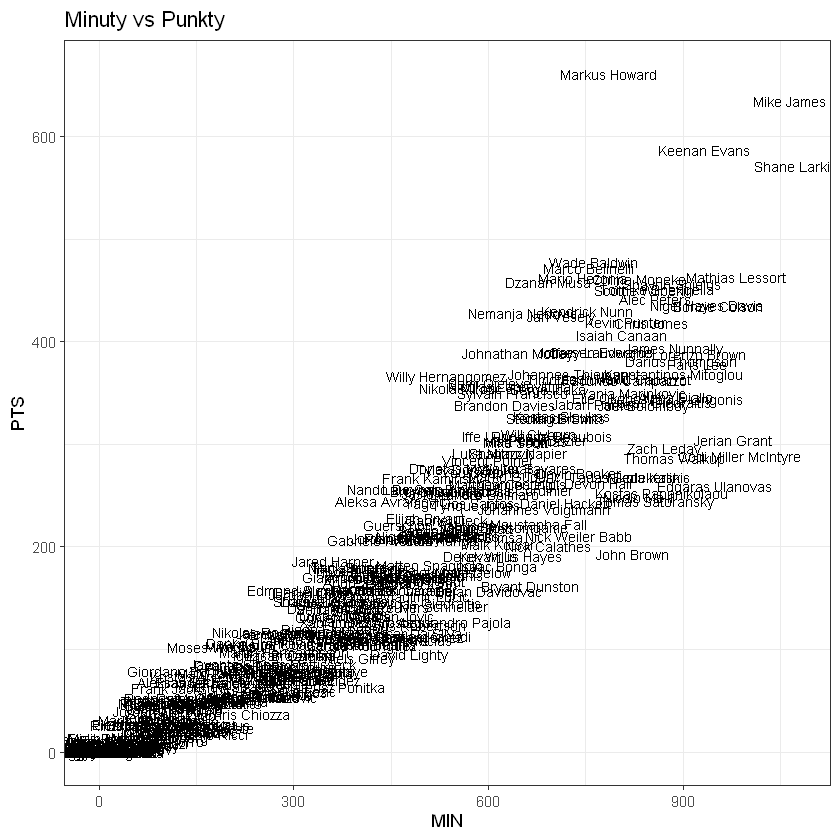

In [141]:
scatterplot(data = pbox_regular,
            data.var = c("MIN", "PTS"),
            title = "Minuty vs Punkty",
            labels = pbox_regular$Player)

In [142]:
ff <- fourfactors(TEAM = tbox_regular, OPP = obox_regular)


In [143]:
str(ff)

Classes 'fourfactors' and 'data.frame':	18 obs. of  15 variables:
 $ Team    : chr  "ALBA" "ASVEL" "Barcelona" "Baskonia" ...
 $ POSS.Off: num  2490 2460 2450 2507 2435 ...
 $ POSS.Def: num  2494 2462 2461 2494 2461 ...
 $ PACE.Off: num  1.83 1.8 1.8 1.84 1.76 ...
 $ PACE.Def: num  1.83 1.8 1.81 1.83 1.78 ...
 $ ORtg    : num  104 109 115 114 110 ...
 $ DRtg    : num  118 117 109 116 113 ...
 $ F1.Off  : num  51.6 52.6 55.7 55.2 53.5 ...
 $ F2.Off  : num  20.6 17.9 17.7 16.9 18.2 ...
 $ F3.Off  : num  30.7 30.1 33.3 29.7 31 ...
 $ F4.Off  : num  19 21.5 19.4 22.1 17.1 ...
 $ F1.Def  : num  58.1 56.4 52.5 54.5 54 ...
 $ F2.Def  : num  18.1 16 16.9 14.7 15.1 ...
 $ F3.Def  : num  66.3 69.5 69.5 70.3 73.2 ...
 $ F4.Def  : num  19.6 20.1 18.6 19.5 23.5 ...


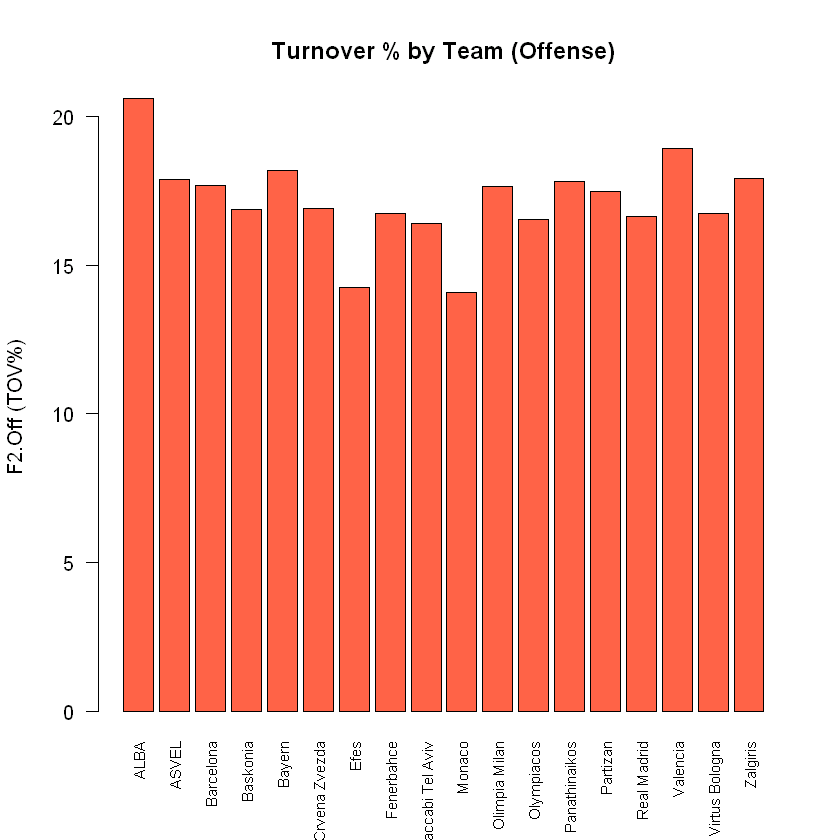

In [144]:
barplot(ff$F2.Off,
        names.arg = ff$Team,
        las = 2, col = "tomato",
        main = "Turnover % by Team (Offense)",
        ylab = "F2.Off (TOV%)",
        cex.names = 0.75)


In [145]:
ff <- ff %>%
  mutate(
    NetRating = ORtg - DRtg,
    FF_Index = 0.4 * F1.Off - 0.25 * F2.Off + 0.2 * F3.Off + 0.15 * F4.Off
  )


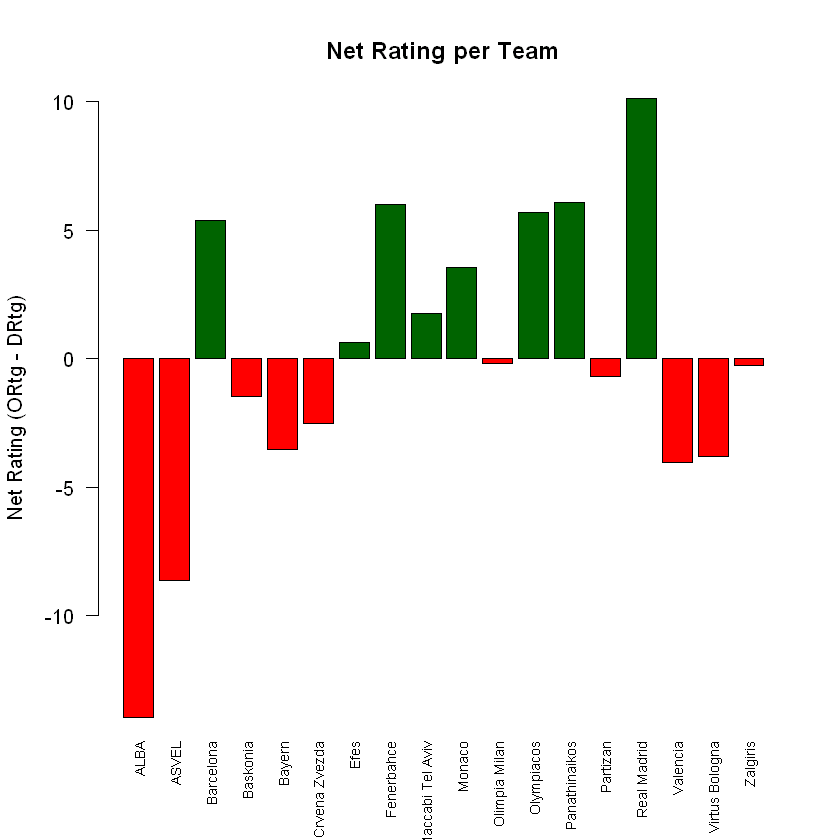

In [146]:
barplot(ff$NetRating,
        names.arg = ff$Team,
        las = 2,
        col = ifelse(ff$NetRating > 0, "darkgreen", "red"),
        main = "Net Rating per Team",
        ylab = "Net Rating (ORtg - DRtg)",
        cex.names = 0.7)


In [147]:
library(ggplot2)

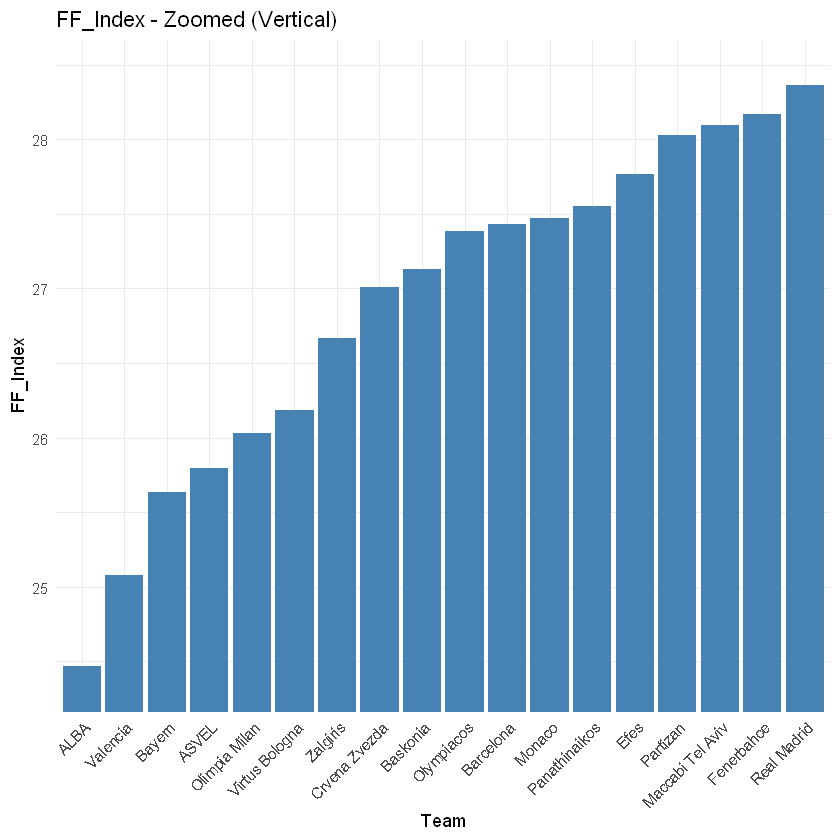

In [148]:
ggplot(ff, aes(x = reorder(Team, FF_Index), y = FF_Index)) +
  geom_col(fill = "steelblue") +
  coord_cartesian(ylim = c(min(ff$FF_Index) - 0.1, max(ff$FF_Index) + 0.1)) +
  labs(title = "FF_Index - Zoomed (Vertical)",
       x = "Team", y = "FF_Index") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [149]:
install.packages("ggforce")

library(grid)     
library(ggforce)  

Warning message:
"pakiet 'ggforce' jest w użyciu i nie zostanie zainstalowany"


In [150]:
shotchart_sector <- function(df, player = NULL, team = NULL) {
  filtered <- df
  if (!is.null(player)) filtered <- filtered %>% filter(Player == player)
  if (!is.null(team)) filtered <- filtered %>% filter(Team == team)
  if (nrow(filtered) == 0) stop("Brak danych po filtrowaniu.")

  zones <- data.frame(
    zone = c("RIM", "PAINT", "MID", "C3", "L3", "H3"),
    made = c(sum(filtered$RIM_M), sum(filtered$PAINT_M), sum(filtered$MID_M),
             sum(filtered$`3C_M`), sum(filtered$`3L_M`), sum(filtered$`3H_M`)),
    att = c(sum(filtered$RIM_A), sum(filtered$PAINT_A), sum(filtered$MID_A),
            sum(filtered$`3C_A`), sum(filtered$`3L_A`), sum(filtered$`3H_A`))
  ) %>%
    mutate(
      FG_perc = ifelse(att > 0, round(100 * made / att, 1), NA),
      label = ifelse(att > 0, paste0(FG_perc, "%\n(", made, "/", att, ")"), "n/a")
    )

  # Dane do geometrii
  rim <- zones %>% filter(zone == "RIM")
  paint <- zones %>% filter(zone == "PAINT")
  mid <- zones %>% filter(zone == "MID")
  c3 <- zones %>% filter(zone == "C3")
  l3 <- zones %>% filter(zone == "L3")
  h3 <- zones %>% filter(zone == "H3")

  # Pozycje etykiet
  labels <- data.frame(
    zone = c("RIM", "PAINT", "MID", "C3L", "C3R", "L3", "H3"),
    x = c(0, 0, 0, -21, 21, 0, 0),
    y = c(5, 12, 20, 3, 3, 30, 43)
  )
  label_data <- bind_rows(
    rim %>% mutate(x = 0, y = 5),
    paint %>% mutate(x = 0, y = 14),
    mid %>% mutate(x = 0, y = 23),
    c3 %>% mutate(x = -25, y = 3),
    c3 %>% mutate(x = 25, y = 3),
    l3 %>% mutate(x = 0, y = 31),
    h3 %>% mutate(x = 0, y = 41.5)
  )

  draw_court <- function() {
    list(
      # Obrys
      geom_rect(aes(xmin = -28, xmax = 28, ymin = 0, ymax = 47), fill = NA, color = "black", size = 1.2),
      geom_segment(aes(x = -28, y = 0, xend = 28, yend = 0), color = "black", size = 1.2),

      # Trumna
      geom_rect(aes(xmin = -8, xmax = 8, ymin = 0, ymax = 19), fill = NA, color = "black", size = 1.2),

      # Linia rzutów wolnych i półkole
      geom_segment(aes(x = -8, y = 19, xend = 8, yend = 19), color = "black", size = 1.2),
      geom_path(data = data.frame(
        x = 6 * cos(seq(0, pi, length.out = 100)),
        y = 6 * sin(seq(0, pi, length.out = 100)) + 19
      ), aes(x = x, y = y), color = "black", size = 1.2),

      # Półkole pod koszem
      geom_path(data = data.frame(
        x = 1.25 * cos(seq(0, pi, length.out = 100)),
        y = 1.25 * sin(seq(0, pi, length.out = 100)) + 5
      ), aes(x = x, y = y), color = "black", size = 1.2),

      # Łuk za 3
      geom_path(data = data.frame(
        x = 22.15 * cos(seq(0.1, pi - 0.1, length.out = 100)),
        y = 22.15 * sin(seq(0.1, pi - 0.1, length.out = 100)) + 5
      ), aes(x = x, y = y), color = "black", size = 1.2),

      # Corner 3
      geom_segment(aes(x = -22, y = 0, xend = -22, yend = 7.5), color = "black", size = 1.2),
      geom_segment(aes(x = 22, y = 0, xend = 22, yend = 7.5), color = "black", size = 1.2)
    )
  }

  ggplot() +
    draw_court() +

    # STREFY
geom_rect(data = rim,
  aes(xmin = -6, xmax = 6, ymin = 2, ymax = 8, fill = FG_perc),
  color = NA, alpha = 0.85) +

geom_rect(data = paint,
  aes(xmin = -6, xmax = 6, ymin = 9, ymax = 18, fill = FG_perc),
  color = NA, alpha = 0.85) +

geom_arc_bar(data = mid,
  aes(x0 = 0, y0 = 5, r0 = 15, r = 21.5,
      start = pi * (-0.5), end = pi * 0.5, fill = FG_perc),
  color = NA, alpha = 0.85) +


geom_rect(data = c3,
  aes(xmin = -28, xmax = -22, ymin = 0, ymax = 7.5, fill = FG_perc),
  color = NA, alpha = 0.85) +

geom_rect(data = c3,
  aes(xmin = 22, xmax = 28, ymin = 0, ymax = 7.5, fill = FG_perc),
  color = NA, alpha = 0.85) +

geom_arc_bar(data = l3,
  aes(x0 = 0, y0 = 5, r0 = 22.75, r = 30,
      start = pi * (-0.35), end = pi * 0.35, fill = FG_perc),
  color = NA, alpha = 0.85) +

geom_rect(data = h3,
  aes(xmin = -25, xmax = 25, ymin = 37, ymax = 46, fill = FG_perc),
  color = NA, alpha = 0.85) +

# Etykiety
geom_text(data = label_data,
  aes(x = x, y = y, label = label),
  color = "white", size = 4) +

    scale_fill_gradient(low = "red", high = "green", na.value = "grey80", name = "FG%") +
    coord_fixed(xlim = c(-28, 28), ylim = c(0, 47)) +
    theme_void() +

    theme(
       plot.title = element_text(hjust = 0, margin = margin(l = 23), size = 14),
       plot.subtitle = element_text(hjust = 0, margin = margin(l = 30), size = 11)
    ) + 
        
    labs(
      title = if (!is.null(player)) paste("Shot Chart –", player) else if
       (!is.null(team)) paste("Shot Chart –", team) else "Shot Chart – Wszyscy gracze"
    )
}


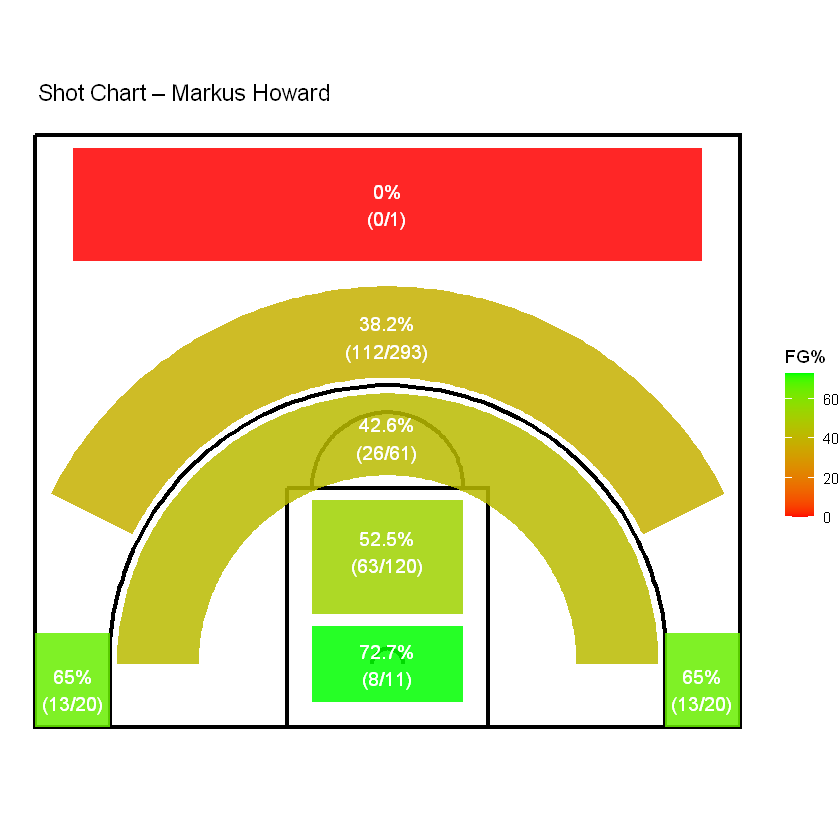

In [151]:
shotchart_sector(pbox_regular, player = "Markus Howard")

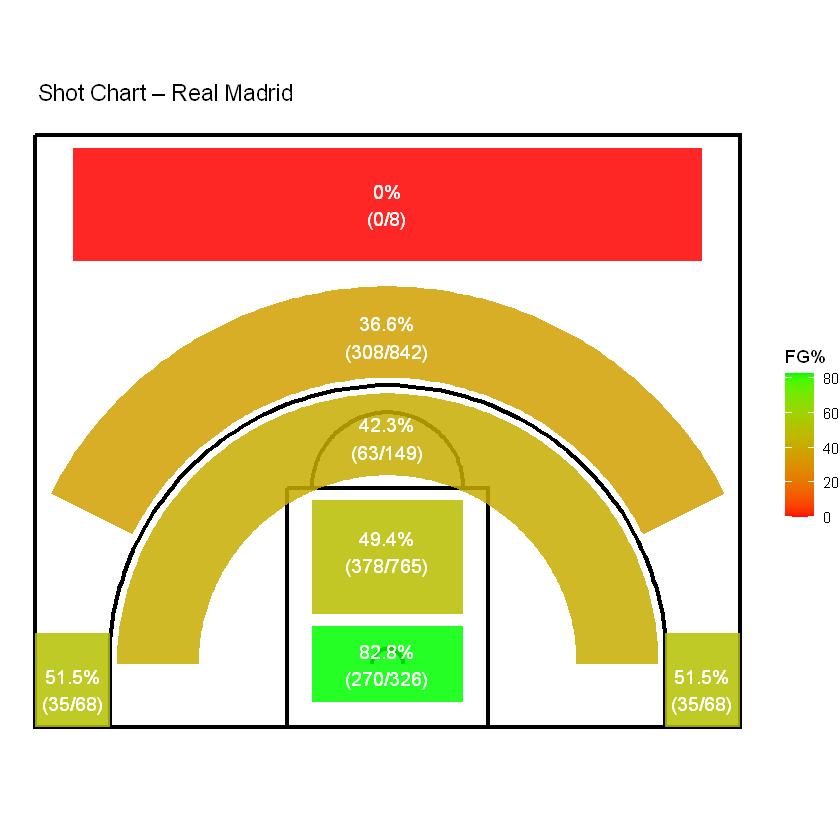

In [152]:
shotchart_sector(tbox_regular, team = "Real Madrid")

**Eksport danych box**

In [153]:
write.csv(pbox_regular, file = "data_box/regular/pbox_regular.csv", row.names = FALSE)
write.csv(tbox_regular, file = "data_box/regular/tbox_regular.csv", row.names = FALSE)
write.csv(obox_regular, file = "data_box/regular/obox_regular.csv", row.names = FALSE)

In [154]:
write.csv(pbox_playin, file = "data_box/playin/pbox_playin.csv", row.names = FALSE)
write.csv(tbox_playin, file = "data_box/playin/tbox_playin.csv", row.names = FALSE)
write.csv(obox_playin, file = "data_box/playin/obox_playin.csv", row.names = FALSE)

In [155]:
write.csv(pbox_playoff, file = "data_box/playoff/pbox_playoff.csv", row.names = FALSE)
write.csv(tbox_playoff, file = "data_box/playoff/tbox_playoff.csv", row.names = FALSE)
write.csv(obox_playoff, file = "data_box/playoff/obox_playoff.csv", row.names = FALSE)

In [156]:
write.csv(pbox_final4, file = "data_box/final4/pbox_final4.csv", row.names = FALSE)
write.csv(tbox_final4, file = "data_box/final4/tbox_final4.csv", row.names = FALSE)
write.csv(obox_final4, file = "data_box/final4/obox_final4.csv", row.names = FALSE)
write.csv(pbox_final4_detailed, file = "data_box/final4/pbox_final4_detailed.csv", row.names = FALSE)

In [157]:
write.csv(t_add, file = "data_box/Tadd/t_add.csv", row.names = FALSE)